구현해야 할 것
- HeatmapParser(post_process, ))
- flipped ensemble evaluation
- (v) mpii_eval 
- (v) generator for mpii_eval(img, gts)

In [1]:
import cv2
import tqdm
import os
import numpy as np
import h5py
import copy

from model import HPE
from data.dp import Dataset

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from utils.group import HeatmapParser
import utils.img

In [2]:
print(tf.config.list_physical_devices('GPU'))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
config = {
    'data_provider': 'data.MPII.dp',
    'network': 'models.posenet.PoseNet',
    'inference': {
        'nstack': 8,
        'inp_dim': 256,
        'oup_dim': 16,
        'num_parts': 16,
        'increase': 0,
        'keys': ['imgs'],
        'num_eval': 2958, ## number of val examples used. entire set is 2958
        'train_num_eval': 300, ## number of train examples tested at test time
    },

    'train': {
        'batchsize': 16,
        'input_res': 256,
        'output_res': 64,
        'train_iters': 1000,
        'valid_iters': 10,
        'learning_rate': 1e-3,
        'max_num_people' : 1,
        'loss': [
            ['combined_hm_loss', 1],
        ],
        'decay_iters': 100000,
        'decay_lr': 2e-4,
        'num_workers': 2,
        'use_data_loader': True,
    },
}

In [4]:
model = HPE()

Model: "HPE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 256, 256, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 128, 128, 64)    9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 128, 128, 64)    256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (1, 128, 128, 64)    0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [5]:
# checkpoint

checkpoint_path = "data/checkpoint/cp-{epoch:04d}.ckpt"
model.load_weights(checkpoint_path.format(epoch=50))

In [6]:
t_ds = Dataset(config, 'valid.h5')
test = tf.data.Dataset.from_generator(t_ds.gen,
                                         output_types=(np.float32, np.float32),
                                         output_shapes=([None, 256, 256, 3], [None, 64, 64, 16]),
                                         args=())

loading data: annot
Done (t=0.37s)


In [7]:
gen = t_ds.gen_eval()

In [10]:
data = next(gen)
result = model.predict(data[0])
hms = result[0]
gts = data[1][0]
n = data[2]

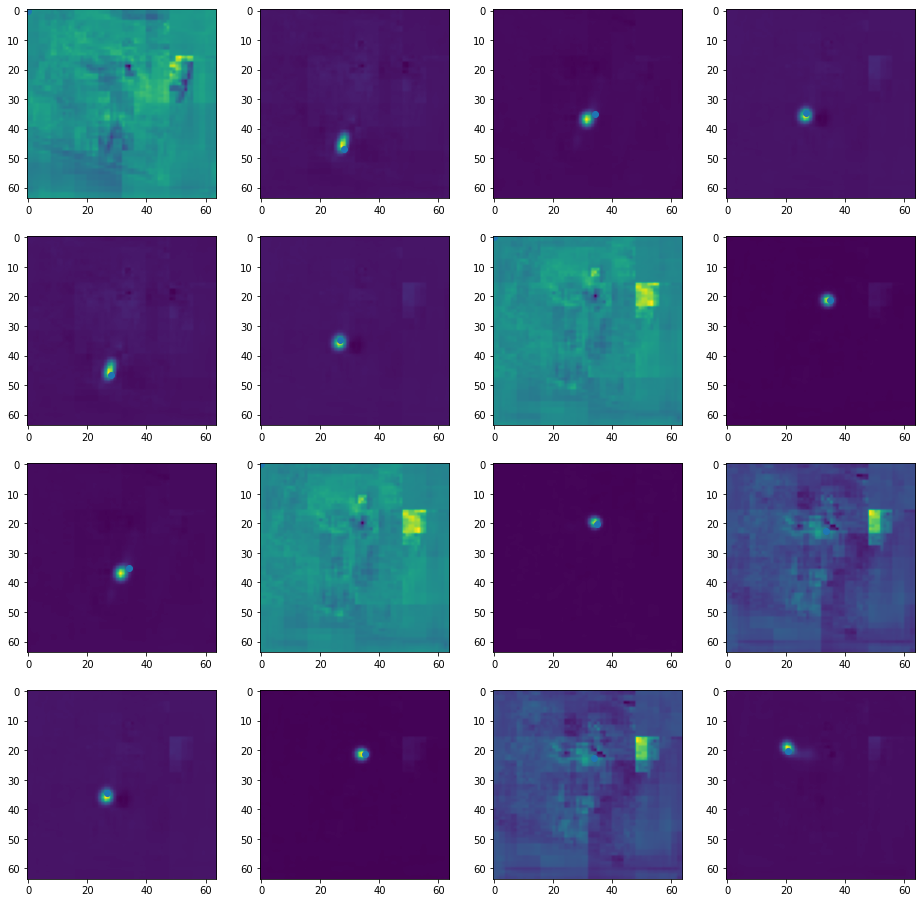

In [12]:
f, axes = plt.subplots(4, 4)
f.set_size_inches((16, 16))
for i in range(4):
    for j in range(4):    
        idx = (i + 1) * (j + 1) - 1
        axes[i][j].imshow(hms[:,:,idx])
        axes[i][j].scatter(gts[idx][0], gts[idx][1])
        # axes[i][j].axis("off")
        
plt.show()

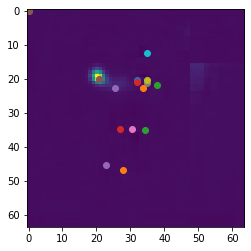

In [14]:
sum_hms = np.zeros((64, 64))
for i in range(16):
    sum_hms += hms[:,:,i]
    plt.imshow(hms[:,:,i])
    plt.scatter(gts[i][0], gts[i][1])
    # axes[i][j].axis("off")
plt.show()

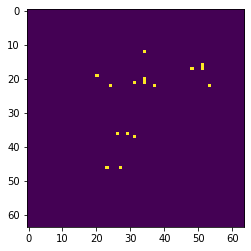

In [17]:
jointmap = np.zeros((64*64), dtype=np.float32)
joint = []
for i in range(hms.shape[2]):
    idx = np.argmax(hms[:,:,i])
    jointmap[idx] = 1
    joint.append((idx % 64, idx // 64))
jointmap = jointmap.reshape((64, 64))
plt.imshow(jointmap)

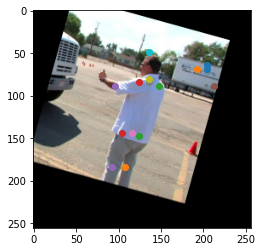

In [18]:
img = np.array(data[0]).reshape((256, 256, 3))

plt.imshow(img)
for j in joint:
    plt.scatter(j[0]/64*256, j[1]/64*256)

In [28]:
def mpii_eval(pred, gt, normalizing, bound=0.5):
    """
    Use PCK with threshold of .5 of normalized distance (presumably head size)
    """

    correct = {'all': {'total': 0, 'ankle': 0, 'knee': 0, 'hip': 0, 'pelvis': 0, 
               'thorax': 0, 'neck': 0, 'head': 0, 'wrist': 0, 'elbow': 0, 
               'shoulder': 0},
               'visible': {'total': 0, 'ankle': 0, 'knee': 0, 'hip': 0, 'pelvis': 0, 
               'thorax': 0, 'neck': 0, 'head': 0, 'wrist': 0, 'elbow': 0, 
               'shoulder': 0},
               'not visible': {'total': 0, 'ankle': 0, 'knee': 0, 'hip': 0, 'pelvis': 0, 
               'thorax': 0, 'neck': 0, 'head': 0, 'wrist': 0, 'elbow': 0, 
               'shoulder': 0}}
    count = copy.deepcopy(correct)
    for p, g, normalize in zip(pred, gt, normalizing):
        for j in range(g.shape[1]):
            vis = 'visible'
            if g[0,j,0] == 0: ## not in picture!
                continue
            if g[0,j,2] == 0:
                vis = 'not visible'
            joint = 'ankle'
            if j==1 or j==4:
                joint = 'knee'
            elif j==2 or j==3:
                joint = 'hip'
            elif j==6:
                joint = 'pelvis'
            elif j==7:
                joint = 'thorax'
            elif j==8:
                joint = 'neck'
            elif j==9:
                joint = 'head'
            elif j==10 or j==15:
                joint = 'wrist'
            elif j==11 or j==14:
                joint = 'elbow'
            elif j==12 or j==13:
                joint = 'shoulder'


            count['all']['total'] += 1
            count['all'][joint] += 1
            count[vis]['total'] += 1
            count[vis][joint] += 1

            error = np.linalg.norm(p[0][j,:2]-g[0,j,:2]) / normalize

            if bound > error:
                correct['all']['total'] += 1
                correct['all'][joint] += 1
                correct[vis]['total'] += 1
                correct[vis][joint] += 1
    
    ## breakdown by validation set / training set
    for k in correct:
        print(k, ':')
        for key in correct[k]:
            print('PCK @,', bound, ',', key, ':', round(correct[k][key] / max(count[k][key],1), 3), ', count:', count[k][key])
        print('\n')

In [30]:
mpii_eval(np.array([hms]), np.array([[gts]]), np.array([n]))

all :
PCK @, 0.5 , total : 0.357 , count: 14
PCK @, 0.5 , ankle : 0.0 , count: 0
PCK @, 0.5 , knee : 0.0 , count: 2
PCK @, 0.5 , hip : 0.0 , count: 2
PCK @, 0.5 , pelvis : 0.0 , count: 1
PCK @, 0.5 , thorax : 0.0 , count: 1
PCK @, 0.5 , neck : 0.0 , count: 1
PCK @, 0.5 , head : 1.0 , count: 1
PCK @, 0.5 , wrist : 1.0 , count: 2
PCK @, 0.5 , elbow : 0.5 , count: 2
PCK @, 0.5 , shoulder : 0.5 , count: 2


visible :
PCK @, 0.5 , total : 0.333 , count: 12
PCK @, 0.5 , ankle : 0.0 , count: 0
PCK @, 0.5 , knee : 0.0 , count: 2
PCK @, 0.5 , hip : 0.0 , count: 2
PCK @, 0.5 , pelvis : 0.0 , count: 1
PCK @, 0.5 , thorax : 0.0 , count: 1
PCK @, 0.5 , neck : 0.0 , count: 1
PCK @, 0.5 , head : 1.0 , count: 1
PCK @, 0.5 , wrist : 1.0 , count: 1
PCK @, 0.5 , elbow : 1.0 , count: 1
PCK @, 0.5 , shoulder : 0.5 , count: 2


not visible :
PCK @, 0.5 , total : 0.5 , count: 2
PCK @, 0.5 , ankle : 0.0 , count: 0
PCK @, 0.5 , knee : 0.0 , count: 0
PCK @, 0.5 , hip : 0.0 , count: 0
PCK @, 0.5 , pelvis : 0.0 ,

In [24]:
print(gts)

[[ 0.          0.          0.        ]
 [27.9398381  46.70777824  1.        ]
 [34.2477537  34.98298339  1.        ]
 [26.79894718 34.58043513  1.        ]
 [22.8908993  45.31399132  1.        ]
 [ 0.          0.          0.        ]
 [30.55365016 34.67194972  1.        ]
 [34.96937214 21.24356517  1.        ]
 [34.77273171 20.24428999  1.        ]
 [34.79684124 12.45476553  1.        ]
 [31.89610504 20.39517313  0.        ]
 [33.66709981 22.53780099  0.        ]
 [37.88371959 21.8118387   1.        ]
 [31.99442526 20.89481072  1.        ]
 [25.37793775 22.61201167  1.        ]
 [20.63199611 20.12062936  1.        ]]


In [5]:
parser = HeatmapParser()

In [38]:
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(hms[:,:,1])
ax1.axis("off")



(-0.5, 63.5, 63.5, -0.5)

In [31]:
print(hms[:,:,0].shape)

(64, 64)


In [6]:
def post_process(det, mat_, trainval, c=None, s=None, resolution=None):
    mat = np.linalg.pinv(np.array(mat_).tolist() + [[0,0,1]])[:2]

    res = det.shape[1:3]
    cropped_preds = parser.parse(np.float32([det]))[0]
    
    if len(cropped_preds) > 0:
        cropped_preds[:,:,:2] = utils.img.kpt_affine(cropped_preds[:,:,:2] * 4, mat) #size 1x16x3
        
    preds = np.copy(cropped_preds)
    ##for inverting predictions from input res on cropped to original image
    if trainval != 'cropped':
        for j in range(preds.shape[1]):
            preds[0,j,:2] = utils.img.transform(preds[0,j,:2], c, s, resolution, invert=1)
    return preds